In [50]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import geopandas as gpd
import re

# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

In [2]:
import os
import cartopy.crs as ccrs
from math import floor
import matplotlib.pyplot as plt
from matplotlib import patheffects
import matplotlib

if os.name == "nt":
    matplotlib.rc("font", family="Arial")
else:  # might need tweaking, must support black triangle for N arrow
    matplotlib.rc("font", family="DejaVu Sans")


def utm_from_lon(lon):
    """
    utm_from_lon - UTM zone for a longitude

    Not right for some polar regions (Norway, Svalbard, Antartica)

    :param float lon: longitude
    :return: UTM zone number
    :rtype: int
    """
    return floor((lon + 180) / 6) + 1


def scale_bar(
    ax, proj, length, location=(0.5, 0.05), linewidth=3, units="km", m_per_unit=1000
):
    """

    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0 + x1) / 2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit / 2, sbcx + length * m_per_unit / 2]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(
        bar_xs,
        [sbcy, sbcy],
        transform=utm,
        color="k",
        linewidth=linewidth,
        path_effects=buffer,
    )
    # buffer for text
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    # Plot the scalebar label
    t0 = ax.text(
        sbcx,
        sbcy,
        str(length) + " " + units,
        transform=utm,
        horizontalalignment="center",
        verticalalignment="bottom",
        path_effects=buffer,
        zorder=2,
    )
    left = x0 + (x1 - x0) * 0.05
    # Plot the N arrow
    t1 = ax.text(
        left,
        sbcy,
        "\u25B2\nN",
        transform=utm,
        horizontalalignment="center",
        verticalalignment="bottom",
        path_effects=buffer,
        zorder=2,
    )
    # Plot the scalebar without buffer, in case covered by text buffer
    ax.plot(
        bar_xs, [sbcy, sbcy], transform=utm, color="k", linewidth=linewidth, zorder=3
    )

In [3]:
ds = xr.open_dataset(
    "/Users/dillonragar/Library/CloudStorage/OneDrive-LynkerTechnologies/2024 CPRA Atchafalaya DSS/data/mp_2023_final_2018_lulc_Clip_reclassed/mp_2023_final_2018_lulc_Clip_reclassed.tif",
    engine="rasterio",
)

In [4]:
filename = "/Users/dillonragar/Library/CloudStorage/OneDrive-LynkerTechnologies/2024 CPRA Atchafalaya DSS/data/mp_2023_final_2018_lulc_Clip_reclassed/mp_2023_final_2018_lulc_Clip_reclassed.tif.vat.dbf"
dbf = gpd.read_file(filename)

In [5]:
dbf["Value"] = dbf["Value"].astype(int)

In [6]:
t_ds = xr.open_dataset("../pct_cover.nc")

In [7]:
t_ds["pct_cover_58"]

<xarray.DataArray 'pct_cover_58' (y: 1918, x: 765)> Size: 12MB
[1467270 values with dtype=float64]
Coordinates:
  * y            (y) float64 15kB 3.432e+06 3.432e+06 ... 3.24e+06 3.24e+06
  * x            (x) float64 6kB 6.003e+05 6.004e+05 ... 6.766e+05 6.767e+05
    band         int32 4B ...
    spatial_ref  int32 4B ...
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        58
    STATISTICS_MEAN:           25.131904763707
    STATISTICS_MINIMUM:        0
    STATISTICS_STDDEV:         19.987804053247
    STATISTICS_VALID_PERCENT:  100

In [8]:
min_lon = t_ds["pct_cover_58"].coords["x"].min().values
max_lon = t_ds["pct_cover_58"].coords["x"].max().values

min_lat = t_ds["pct_cover_58"].coords["y"].min().values
max_lat = t_ds["pct_cover_58"].coords["y"].max().values

In [9]:
gdf = gpd.read_file(
    "/Users/dillonragar/Library/CloudStorage/OneDrive-LynkerTechnologies/2024 CPRA Atchafalaya DSS/data/Atchafalaya MP WPUs/Atchafalaya MP WPUs.shp"
)

In [10]:
gdf = gdf.to_crs(crs)

NameError: name 'crs' is not defined

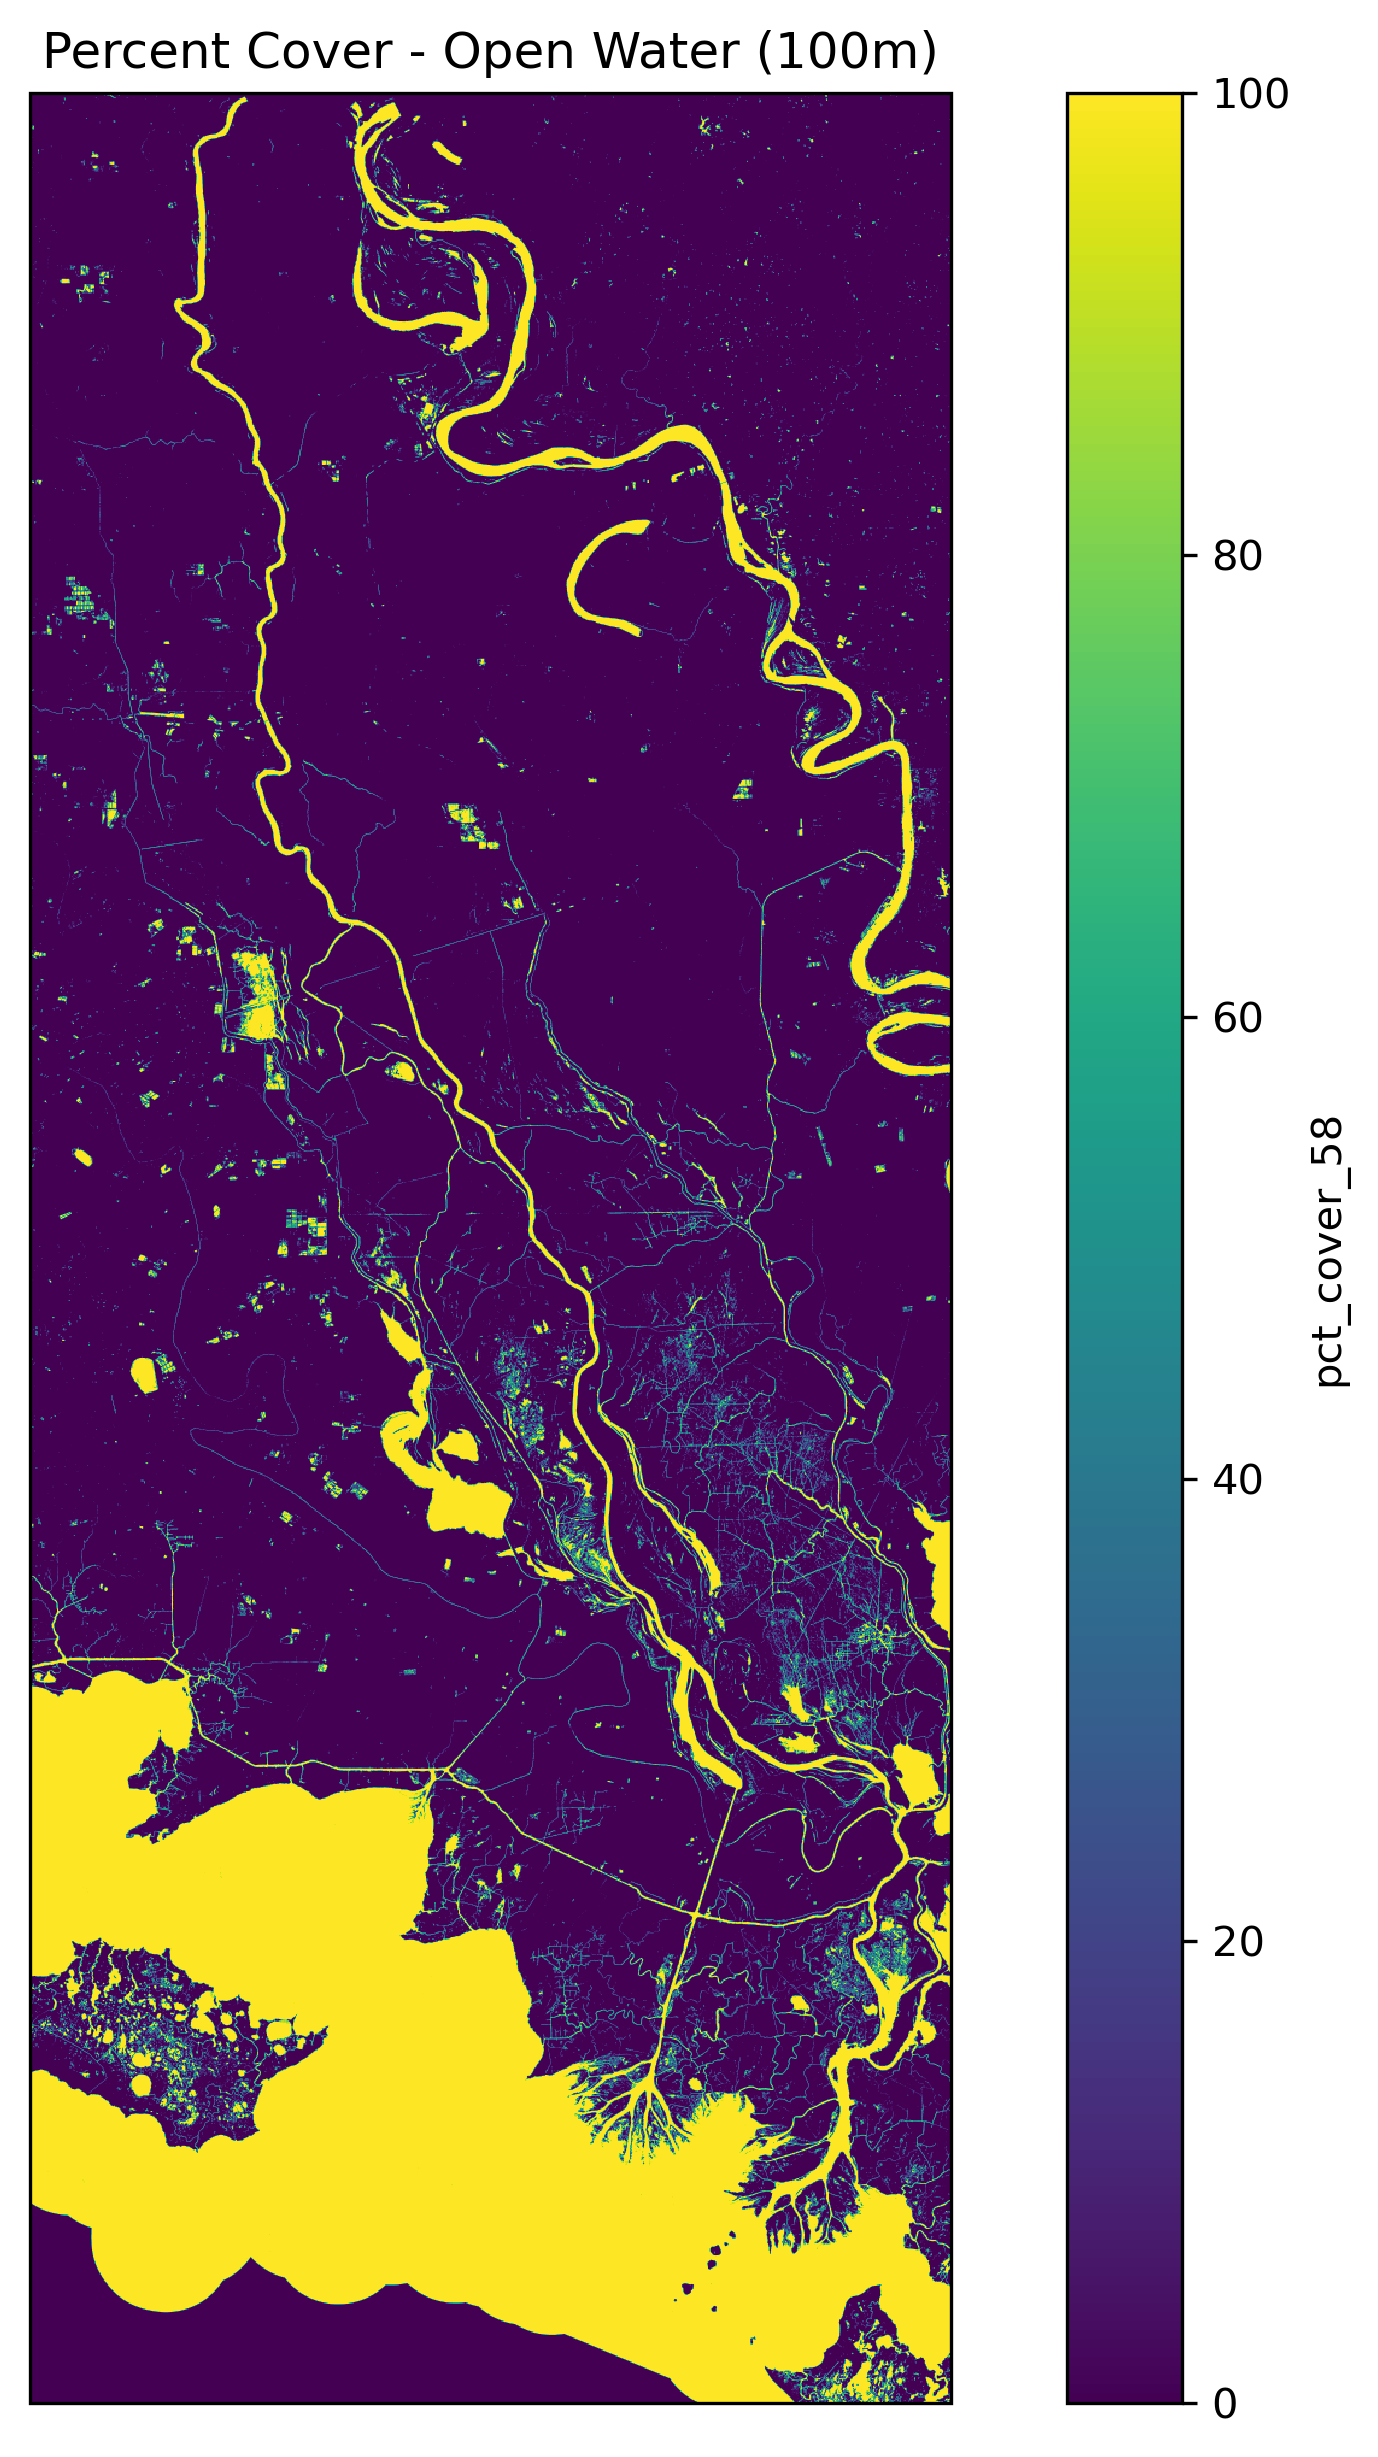

In [11]:
# from __future__ import division

import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

crs = ccrs.UTM("15")
# Defining the figure
fig = plt.figure(figsize=(10, 10), facecolor="w", edgecolor="k", dpi=300)
# Axes with Cartopy projection
ax = plt.axes(projection=crs)


ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs)

t_ds["pct_cover_58"].plot.imshow(ax=ax, transform=crs)
plt.title("Percent Cover - Open Water (100m)")

# gdf.plot(edgecolor='white', facecolor='none', linewidth=0.4, ax=ax)
# scale_bar(ax, crs, 10)  # 100 km scale bar
plt.show()

In [25]:
veg_path = "/Users/dillonragar/Library/CloudStorage/OneDrive-LynkerTechnologies/2024 CPRA Atchafalaya DSS/data/mp_2023_final_2018_lulc_Clip_reclassed/mp_2023_final_2018_lulc_Clip_reclassed.tif.vat.dbf"
dbf = gpd.read_file(veg_path)
# fix dtype
dbf["Value"] = dbf["Value"].astype(int)
df = dbf[["Value", "Class"]]

In [61]:
for i, v in df.iterrows():
    veg_type, veg_int = v["Class"], v["Value"]
    # print(veg_int)

    crs = ccrs.UTM("15")
    # Defining the figure
    fig = plt.figure(figsize=(6, 8), facecolor="w", edgecolor="k", dpi=300)
    # Axes with Cartopy projection
    ax = plt.axes(projection=crs)
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs)

    t_ds[f"pct_cover_{veg_int}"].plot.imshow(ax=ax, transform=crs)
    plt.title(f"Percent Cover - {veg_type} (100m)")

    # gdf.plot(edgecolor='white', facecolor='none', linewidth=0.4, ax=ax)
    # scale_bar(ax, crs, 10)  # 100 km scale bar
    # plt.show()

    veg_lower = re.sub(r"[ /-]", "_", veg_type.lower())
    # Remove consecutive underscores
    veg_lower = re.sub(r"_+", "_", veg_lower)

    print(veg_lower)
    plt.savefig(f"./output/pct_cover_{veg_lower}_100m.png")
    plt.close()

developed_high_intensity
developed_medium_intensity
developed_low_intensity
developed_open_space
cultivated_crops
pasture_hay
grassland_herbaceous
upland_mixed_deciduous_forest
upland_mixed_evergreen_forest
upland_mixed_forest
upland_scrub_shrub
unconsolidated_shore
bare_land
zone_v
zone_iv
zone_iii
zone_ii
deciduous_shrub_scrub_species_mixed
elba2_flt
moce2
zimi
pahe2
pahe2_flt
coes
sala
tydo
popu5
clma10
elce
scca11
pava
phau7
scro5
ivfr
scam6
sppa
spcy
disp
juro
spal
avge
palustrine_aquatic_bed
estuarine_aquatic_bed
open_water


In [128]:
def coarsen_and_reduce(da: xr.DataArray, veg_type: int, **kwargs) -> xr.DataArray:
    """execute `.coarsen` and `.reduce`, with args handled
    by this function, due to xarray bug (described below).

    Combined, these functions allow the raw veg raster to be
    downsampled into an individual array containing pct cover
    of a single constituent vegetation classes.

    :param (xr.DataArray) da: DataArray containing single-band veg raster
    :param (int) veg_type: single vegetation type to use as a pct cover
        value for the new, downsampled veg array.

    :return (xr.DataArray): Downsampled array with pct cover for a SINGLE veg type.
    """

    def _count_vegtype_and_calculate_percentage(block, axis):
        """Get percentage cover of vegetation types in pixel group

        NOTE: This function is nested as a work-around to the kwargs bug
        in DataArray.reduce, described here:
        https://github.com/pydata/xarray/issues/8059. This avoids having
        to use a global variable to provide args to the `.reduce` call.


        :param (np.ndarray) block: non-overlapping chunks from `.coarsen` function.
        :param (tuple) axis: used to index the chunks, which are returned with dims
            based on the coarsen dims.
        :return (np.ndarray): coarsened chunk
        """
        # Sum over the provided axis
        count = (block == veg_type).sum(axis=axis)
        total_cells = block.shape[axis[0]] * block.shape[axis[1]]
        return (count / total_cells) * 100

    result = da.coarsen(**kwargs).reduce(_count_vegtype_and_calculate_percentage)

    return result

In [148]:
# Set dimensions
x_dim = 4  # Number of points along the x-axis
y_dim = 4  # Number of points along the y-axis

# Create random data between 1 and 5
data = np.random.randint(1, 6, size=(x_dim, y_dim))

# Create an xarray DataArray
da = xr.DataArray(data, dims=["x", "y"], coords={"x": range(x_dim), "y": range(y_dim)}, name="random_data")
da

<xarray.DataArray 'random_data' (x: 4, y: 4)> Size: 128B
array([[2, 1, 5, 5],
       [1, 2, 2, 3],
       [1, 3, 2, 5],
       [1, 4, 2, 1]])
Coordinates:
  * x        (x) int64 32B 0 1 2 3
  * y        (y) int64 32B 0 1 2 3

In [149]:
veg_types = [1,2]


#(np.array([[2,3],[1,3]]) == [1,3]).sum(axis=1)

da['binary'] = (["x", "y"], np.isin(da, veg_types))

In [151]:
da['binary']

<xarray.DataArray 'binary' (x: 4, y: 4)> Size: 16B
array([[ True,  True, False, False],
       [ True,  True,  True, False],
       [ True, False,  True, False],
       [ True, False,  True,  True]])
Coordinates:
  * x        (x) int64 32B 0 1 2 3
  * y        (y) int64 32B 0 1 2 3
    binary   (x, y) bool 16B True True False False True ... True False True True

In [156]:
res = coarsen_and_reduce(veg_type = True, da = da['binary'], x=2, y=2)

[[[[ True  True]
   [False False]]

  [[ True  True]
   [ True False]]]


 [[[ True False]
   [ True False]]

  [[ True False]
   [ True  True]]]]
count=array([[4, 1],
       [2, 3]])
total_cells=4


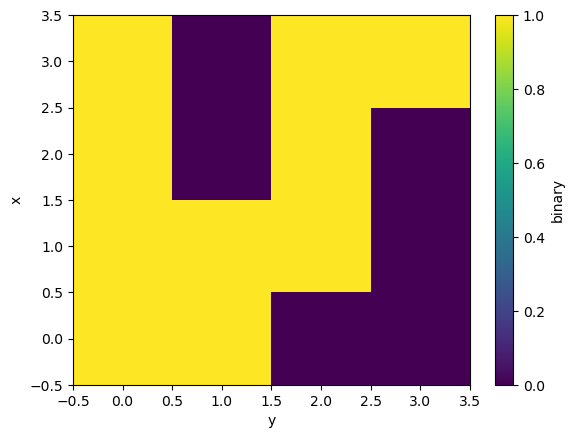

In [157]:
da['binary'].plot()

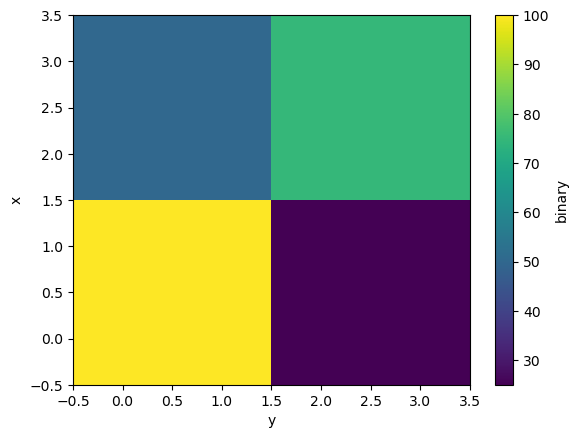

In [158]:
res.plot()